In [ ]:
import sys

sys.path.append('../')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *

In [ ]:
os.environ['ncpus'] = '0'
torch.cuda.set_device(1)
set_global_pool(cpus=64)

# Penalized LogP

In [ ]:
set_global_pool(cpus=10)

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     ],
                    [PropertyFilter(penalized_logp, None, None, score=PassThroughScore())], 
                    fail_score=-1., log=False)

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_nc.pt'))

<All keys matched successfully>

In [ ]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [ ]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [ ]:
template_cb = TemplateCallback(template, prefilter=True)

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[], loss_cbs=[loss],
                 cbs=cbs)

In [ ]:
env.fit(200, 90, 10, 1)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
0,-0.172,-0.172,1.000,1.000,200,-0.172,1.000,1.000,1.000,-0.274,1.000,0.773,1.544,3.067
1,-0.265,-0.265,1.000,1.000,200,-0.265,1.000,1.000,1.000,-0.199,1.000,0.560,1.650,3.247
2,0.037,0.037,1.000,1.000,200,0.037,1.000,1.000,1.000,-0.012,1.000,0.531,1.870,2.969
3,-0.167,-0.167,1.000,1.000,200,-0.167,1.000,1.000,1.000,-0.241,1.000,0.532,1.707,2.987
4,0.039,0.039,1.000,1.000,200,0.039,1.000,1.000,1.000,-0.013,1.000,0.475,1.781,2.808
5,-0.287,-0.287,1.000,1.000,199,-0.287,0.995,1.000,0.992,-0.224,1.000,0.525,1.670,3.078
6,-0.031,-0.031,1.000,1.000,200,-0.031,1.000,1.000,1.000,-0.004,1.000,0.434,1.743,2.281
7,-0.007,-0.007,1.000,1.000,198,-0.007,0.990,1.000,0.983,0.103,1.000,0.450,1.500,2.659
8,-0.112,-0.112,1.000,1.000,200,-0.112,1.000,1.000,1.000,-0.117,1.000,0.491,1.834,2.701
9,0.067,0.067,1.000,1.000,200,0.067,1.000,1.000,1.000,0.148,1.000,0.431,1.668,3.266


In [ ]:
env.log.batch_log.keys()

dict_keys(['samples', 'sources', 'rewards', 'rewards_final', 'template', 'PPO'])

In [ ]:
env.log.metrics.keys()

dict_keys(['rewards', 'rewards_final', 'new', 'diversity', 'bs', 'template', 'valid', 'live_diversity', 'live_valid', 'live_rewards', 'live_new', 'PPO', 'rewards_live_p90', 'rewards_live_max'])

In [ ]:
env.log.metrics['rewards']

[-0.1716146,
 -0.2653873,
 0.03724349,
 -0.16676873,
 0.039491408,
 -0.28679237,
 -0.031179694,
 -0.0068279807,
 -0.11219723,
 0.06705659]

In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
0,-0.004,-0.004,1.000,1.000,200,-0.004,1.000,1.000,1.000,-0.068,1.000,0.474,1.661,2.999
10,-0.166,-0.166,1.000,1.000,200,-0.166,1.000,1.000,1.000,-0.182,1.000,0.429,1.681,2.650
20,0.176,0.176,1.000,1.000,200,0.176,1.000,1.000,1.000,0.128,1.000,0.383,1.577,2.579
30,0.095,0.095,0.980,1.000,200,0.095,1.000,1.000,1.000,0.172,1.000,0.480,1.731,3.503
40,0.079,0.079,0.970,1.000,199,0.079,0.995,1.000,0.992,-0.072,1.000,0.398,1.429,2.072
50,0.000,0.000,0.975,1.000,199,0.000,0.995,1.000,0.992,-0.113,1.000,0.488,1.661,3.262
60,0.033,0.033,0.980,1.000,200,0.033,1.000,1.000,1.000,0.185,1.000,0.420,1.865,2.731
70,0.077,0.077,0.975,1.000,200,0.077,1.000,1.000,1.000,0.231,1.000,0.560,1.947,4.160
80,0.110,0.110,0.970,1.000,200,0.110,1.000,1.000,1.000,-0.044,1.000,0.599,2.029,3.316
90,0.122,0.122,0.990,1.000,200,0.122,1.000,1.000,1.000,0.173,1.000,0.446,2.016,3.918


Epoch,Train Loss,Valid Loss,Time
0,0.34030,0.30274,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.27648,0.27263,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.24494,0.27685,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.20487,0.20692,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.21370,0.23391,00:03


In [ ]:
env.fit(200, 90, 500, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
1000,5.136,5.136,0.868,1.000,190,5.136,0.950,1.000,0.917,5.786,0.882,0.365,7.456,8.814
1010,5.654,5.654,0.842,1.000,190,5.654,0.950,1.000,0.917,5.736,0.882,0.329,7.421,8.688
1020,5.786,5.786,0.832,1.000,185,5.786,0.925,1.000,0.875,6.041,0.876,0.332,7.572,8.727
1030,5.986,5.986,0.840,1.000,187,5.986,0.935,1.000,0.892,6.401,0.925,0.366,8.090,9.038
1040,5.934,5.934,0.836,0.995,183,5.934,0.915,1.000,0.858,6.095,0.864,0.285,7.599,9.101
1050,5.946,5.946,0.887,1.000,177,5.946,0.885,1.000,0.808,6.165,0.918,0.336,7.902,9.553
1060,5.952,5.952,0.876,1.000,169,5.952,0.845,1.000,0.742,6.104,0.910,0.273,7.446,8.937
1070,6.171,6.171,0.837,1.000,172,6.171,0.860,1.000,0.767,6.247,0.913,0.282,7.862,8.770
1080,6.088,6.088,0.871,1.000,171,6.088,0.855,1.000,0.758,6.200,0.890,0.305,7.785,9.781
1090,6.070,6.070,0.848,1.000,164,6.070,0.820,1.000,0.700,6.402,0.881,0.371,8.145,8.890


Epoch,Train Loss,Valid Loss,Time
0,0.21971,0.21185,00:03


Epoch,Train Loss,Valid Loss,Time
0,0.20963,0.18371,00:04


In [ ]:
env.fit(200, 120, 500, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
1500,9.445,9.445,0.881,1.000,194,9.445,0.970,1.000,0.950,9.981,0.939,0.291,11.275,11.749
1510,9.575,9.575,0.929,1.000,198,9.575,0.990,1.000,0.983,9.731,0.983,0.183,10.749,12.342
1520,9.691,9.691,0.932,1.000,190,9.691,0.950,1.000,0.917,9.907,0.973,0.245,11.282,12.405
1530,9.863,9.863,0.943,1.000,192,9.863,0.960,1.000,0.933,10.032,0.964,0.209,11.042,12.319
1540,9.999,9.999,0.953,1.000,192,9.999,0.960,1.000,0.933,10.198,0.955,0.230,11.428,12.496
1550,9.896,9.896,0.908,1.000,196,9.896,0.980,1.000,0.967,10.051,0.922,0.187,11.125,11.863
1560,10.106,10.106,0.938,1.000,192,10.106,0.960,1.000,0.933,10.323,0.973,0.224,11.392,11.990
1570,10.239,10.239,0.948,1.000,191,10.239,0.955,1.000,0.925,10.368,0.982,0.178,11.402,12.424
1580,10.133,10.133,0.959,1.000,195,10.133,0.975,1.000,0.958,10.471,0.957,0.232,11.501,12.553
1590,10.278,10.278,0.968,1.000,188,10.278,0.940,1.000,0.900,10.575,0.991,0.196,11.414,12.582


Epoch,Train Loss,Valid Loss,Time
0,0.17395,0.17516,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.16446,0.16642,00:06


Epoch,Train Loss,Valid Loss,Time
0,0.14194,0.15887,00:07


In [ ]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)

In [ ]:
log_df[log_df.rewards>14]

,samples,sources,rewards,rewards_final,template,PPO
295915,Cc1ccccc1Oc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-...,live,14.247668,14.247668,14.247668,-2.354299
295919,COc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1...,live,14.004727,14.004727,14.004727,-2.197066
296227,Cc1ccccc1Oc1ccccc1-c1ccccc1-c1ccccc1Oc1ccccc1O...,live,14.074106,14.074106,14.074106,-1.438664
297832,Cc1ccccc1COc1ccccc1-c1ccccc1CSc1ccccc1Oc1ccccc...,live,14.103390,14.103390,14.103390,-2.725281
299089,Cc1cccc(-c2ccccc2-c2ccccc2-c2ccccc2-c2ccccc2)c...,live,14.104730,14.104730,14.104730,-2.615992
300616,Cc1cc(Oc2ccccc2-c2ccccc2-c2ccccc2)ccc1Oc1ccccc...,buffer,14.085360,14.085360,14.085360,-1.910619
302258,Cc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-...,live,14.219254,14.219254,14.219254,-2.618345
304003,COc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1...,live,14.028235,14.028235,14.028235,-2.852698
304847,Cc1ccccc1-c1cc(-c2ccccc2)ccc1-c1ccccc1-c1ccccc...,live,14.143243,14.143243,14.143242,-2.181055
306561,COc1ccccc1-c1ccccc1-c1ccccc1-c1ccccc1Sc1ccccc1...,live,14.013198,14.013198,14.013198,-1.866746


In [ ]:
log_df.rewards.nlargest(3)

316548    14.576519
314989    14.404551
313461    14.343534
Name: rewards, dtype: float32

# QED

In [ ]:
set_global_pool(cpus=10)

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     ],
                    [QEDFilter(None, None, score=PassThroughScore())], 
                    fail_score=-1., log=False)

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_nc.pt'))

<All keys matched successfully>

In [ ]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [ ]:
gen_bs = 1500

# sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0., gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)

samplers = [sampler1, sampler2, sampler3, sampler4]

In [ ]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
# live_max = MaxCallback('rewards', 'live')
# live_p90 = PercentileCallback('rewards', 'live', 90)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [ ]:
template_cb = TemplateCallback(template, prefilter=True)

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[], loss_cbs=[loss],
                 cbs=cbs)

In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
0,0.740,0.740,1.000,1.000,200,0.740,1.000,1.000,1.000,0.742,1.000,-0.065,0.858,0.921
10,0.754,0.754,1.000,1.000,200,0.754,1.000,1.000,1.000,0.757,1.000,-0.064,0.879,0.927
20,0.737,0.737,1.000,1.000,200,0.737,1.000,1.000,1.000,0.736,1.000,-0.069,0.875,0.921
30,0.748,0.748,0.990,1.000,200,0.748,1.000,1.000,1.000,0.745,1.000,-0.063,0.873,0.942
40,0.757,0.757,0.985,1.000,200,0.757,1.000,1.000,1.000,0.753,1.000,-0.082,0.895,0.933
50,0.746,0.746,0.980,1.000,199,0.746,0.995,1.000,0.992,0.745,1.000,-0.092,0.879,0.930
60,0.736,0.736,0.995,1.000,199,0.736,0.995,1.000,0.992,0.739,1.000,-0.076,0.862,0.923
70,0.748,0.748,0.995,1.000,200,0.748,1.000,1.000,1.000,0.751,1.000,-0.076,0.870,0.928
80,0.762,0.762,0.980,1.000,200,0.762,1.000,1.000,1.000,0.757,1.000,-0.060,0.884,0.919
90,0.750,0.750,0.970,1.000,200,0.750,1.000,1.000,1.000,0.745,1.000,-0.085,0.870,0.936


Epoch,Train Loss,Valid Loss,Time
0,0.38925,0.38746,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.37670,0.37570,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.34557,0.36167,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.32102,0.32601,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.30335,0.25101,00:01


In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
1000,0.895,0.895,0.630,1.000,200,0.895,1.000,1.000,1.000,0.900,0.525,-0.035,0.942,0.947
1010,0.899,0.899,0.595,1.000,200,0.899,1.000,1.000,1.000,0.900,0.517,-0.033,0.943,0.947
1020,0.903,0.903,0.680,1.000,200,0.903,1.000,1.000,1.000,0.901,0.617,-0.040,0.943,0.946
1030,0.903,0.903,0.615,1.000,200,0.903,1.000,1.000,1.000,0.911,0.517,-0.032,0.943,0.948
1040,0.909,0.909,0.595,1.000,200,0.909,1.000,1.000,1.000,0.909,0.542,-0.030,0.943,0.948
1050,0.902,0.902,0.610,1.000,200,0.902,1.000,1.000,1.000,0.913,0.500,-0.048,0.943,0.947
1060,0.906,0.906,0.625,1.000,200,0.906,1.000,1.000,1.000,0.910,0.517,-0.039,0.944,0.948
1070,0.913,0.913,0.600,1.000,200,0.913,1.000,1.000,1.000,0.918,0.500,-0.035,0.944,0.948
1080,0.907,0.907,0.530,0.995,200,0.907,1.000,0.992,1.000,0.910,0.433,-0.024,0.944,0.948
1090,0.904,0.904,0.563,0.995,197,0.904,0.985,1.000,0.975,0.907,0.470,-0.028,0.943,0.947


Epoch,Train Loss,Valid Loss,Time
0,0.28793,0.25787,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.27699,0.26661,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.21904,0.27016,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.25579,0.26358,00:02


Epoch,Train Loss,Valid Loss,Time
0,0.23203,0.25094,00:02


In [ ]:
log_df = env.log.df
log_df.drop_duplicates(subset='samples', inplace=True)

In [ ]:
log_df[log_df.rewards>0.9483]

,samples,sources,rewards,rewards_final,template,PPO
84602,Cc1cncc(CNC(=O)C2CC23CCOc2ccccc23)c1,live,0.948335,0.948335,0.948335,-1.383738
105868,Cc1ccc(NC(=O)c2cnn(C3CCOC3)c2C)c(F)c1,buffer,0.948313,0.948313,0.948313,-1.244726
182332,CC1(NC(=O)c2csc(-c3ccc(F)cc3)n2)CCOC1,buffer,0.948420,0.948420,0.948420,-0.688382
195363,Cc1cc(N2CCC(NC(=O)c3ccccc3)C2)ccc1C#N,buffer,0.948380,0.948380,0.948380,-0.617402
209863,Cc1cccc(N2CCC(NC(=O)c3ccccc3)C2)c1C#N,buffer,0.948380,0.948380,0.948380,-0.596218
211433,Cc1cccc(N2CCC(NC(=O)c3cccc(C#N)c3)C2)c1,buffer,0.948380,0.948380,0.948380,-0.564223
213652,Cc1cccc(C(=O)NC2CCN(c3ccccc3C#N)C2)c1,live,0.948380,0.948380,0.948380,-0.538738
215858,Cc1ccc(N2CCC(NC(=O)c3ccccc3)C2)cc1C#N,buffer,0.948380,0.948380,0.948380,-0.511670
220703,Cc1ccccc1C(=O)NC1CCN(c2ccccc2C#N)C1,buffer,0.948380,0.948380,0.948380,-0.529508
220780,Cc1cccc(C(=O)NC2CCN(c3ccc(C#N)cc3)C2)c1,live,0.948380,0.948380,0.948380,-0.464843


In [ ]:
log_df.rewards.nlargest(3)

182332    0.94842
195363    0.94838
209863    0.94838
Name: rewards, dtype: float32

Beats https://arxiv.org/pdf/2001.09382.pdf

Natural

# QED + SA

In [ ]:
def scale_sa(sa):
    return (10-sa)/9

template = Template([ValidityFilter(), 
                     SingleCompoundFilter()],
                    [QEDFilter(None, None, score=PassThroughScore()),
                     SAFilter(None, None, score=PropertyFunctionScore(scale_sa))], 
                    fail_score=-1., log=False)

In [ ]:
set_global_pool(cpus=10)

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_nc.pt'))

<All keys matched successfully>

In [ ]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)
sampler5 = LogEnumerator('samples', 'rewards', 10, 95, 3, atom_types=['C', 'N', 'O', -1, -2])

samplers = [sampler1, sampler2, sampler3, sampler4, sampler5]

In [ ]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [ ]:
template_cb = TemplateCallback(template, prefilter=True)

env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[], loss_cbs=[loss],
                 cbs=cbs)

In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
0,1.510,1.510,1.000,1.000,199,1.510,0.995,1.000,0.992,1.509,1.000,-0.041,1.672,1.814
10,1.501,1.501,1.000,1.000,200,1.501,1.000,1.000,1.000,1.499,1.000,-0.080,1.664,1.817
20,1.509,1.509,1.000,1.000,200,1.509,1.000,1.000,1.000,1.508,1.000,-0.065,1.655,1.782
30,1.520,1.520,1.000,1.000,199,1.520,0.995,1.000,0.992,1.512,1.000,-0.064,1.672,1.787
40,1.516,1.516,0.985,1.000,200,1.516,1.000,1.000,1.000,1.510,1.000,-0.071,1.675,1.782
50,1.510,1.510,0.985,1.000,200,1.510,1.000,1.000,1.000,1.503,1.000,-0.090,1.666,1.804
60,1.535,1.535,0.985,1.000,200,1.535,1.000,1.000,1.000,1.537,1.000,-0.059,1.681,1.774
70,1.512,1.512,0.985,1.000,200,1.512,1.000,1.000,1.000,1.509,1.000,-0.100,1.657,1.747
80,1.519,1.519,0.970,1.000,200,1.519,1.000,1.000,1.000,1.501,1.000,-0.070,1.651,1.791
90,1.535,1.535,0.980,1.000,198,1.535,0.990,1.000,0.983,1.545,1.000,-0.071,1.662,1.770


Epoch,Train Loss,Valid Loss,Time
0,0.39588,0.38603,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.36959,0.35368,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.32576,0.34214,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.29976,0.25351,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.24314,0.24024,00:01


In [ ]:
env.fit(200, 90, 1000, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
1000,1.812,1.812,0.460,0.995,200,1.812,1.000,0.992,1.000,1.824,0.400,-0.046,1.870,1.878
1010,1.815,1.815,0.425,0.995,200,1.815,1.000,1.000,1.000,1.832,0.300,-0.039,1.868,1.884
1020,1.819,1.819,0.410,1.000,200,1.819,1.000,1.000,1.000,1.827,0.300,-0.036,1.874,1.888
1030,1.820,1.820,0.445,0.995,200,1.820,1.000,1.000,1.000,1.825,0.350,-0.042,1.869,1.894
1040,1.824,1.824,0.394,0.990,198,1.824,0.990,0.983,0.983,1.827,0.305,-0.039,1.875,1.888
1050,1.818,1.818,0.402,0.995,199,1.818,0.995,0.992,0.992,1.824,0.286,-0.047,1.869,1.889
1060,1.819,1.819,0.375,0.990,200,1.819,1.000,1.000,1.000,1.825,0.300,-0.051,1.870,1.894
1070,1.822,1.822,0.420,0.990,200,1.822,1.000,0.992,1.000,1.831,0.317,-0.051,1.869,1.890
1080,1.824,1.824,0.420,0.995,200,1.824,1.000,0.992,1.000,1.831,0.375,-0.041,1.877,1.888
1090,1.828,1.828,0.350,0.995,200,1.828,1.000,1.000,1.000,1.833,0.292,-0.045,1.876,1.888


Epoch,Train Loss,Valid Loss,Time
0,0.23878,0.24366,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.23802,0.25913,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.25527,0.23870,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.21090,0.23846,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.23778,0.23221,00:01


In [ ]:
env.log.df[env.log.df.rewards>1.9]

,samples,sources,rewards,rewards_final,template,PPO
172067,COc1ccc(NC(=O)c2ccc(Br)cc2)cc1,live,1.901296,1.901296,1.901296,-1.128514
189112,COc1ccc(C(=O)Nc2ccc(Br)cc2)cc1,live,1.901296,1.901296,1.901296,-1.141182


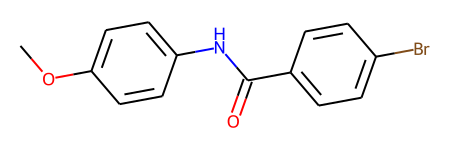

In [ ]:
to_mol('COc1ccc(NC(=O)c2ccc(Br)cc2)cc1')

In [ ]:
env.log.get_df().sources.value_counts()

live                     239297
live_buffer               71497
base_buffer               68201
rewards_enum_buffer       13323
rewards_sample_buffer      6979
Name: sources, dtype: int64

# Constrained LogP

In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

ds = Text_Dataset(['C'], vocab)
supervised_loss = CrossEntropy()

d_vocab = len(vocab.itos)
d_embedding = 256
d_hidden = 1024
n_layers = 3
input_dropout = 0.
lstm_dropout = 0.
bos_idx = vocab.stoi['bos']
bidir = False
tie_weights = True

model = LSTM_LM(d_vocab, 
                d_embedding,
                d_hidden, 
                n_layers,
                input_dropout,
                lstm_dropout,
                bos_idx, 
                bidir, 
                tie_weights)

model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_nc.pt'))

<All keys matched successfully>

In [ ]:
agent = GenerativeAgent(model, vocab, supervised_loss, ds, opt_kwargs={'lr':5e-6},
                       base_update_iter=5, base_update=.97)

In [ ]:
base_smile = 'COCC1=CC(C[NH]CC(=O)NC2CCCCCCC2)=N[NH]1'
base_smile2 = 'COCC1=CC(C[NH2+]CC(=O)NC2CCCCCCC2)=N[NH]1'

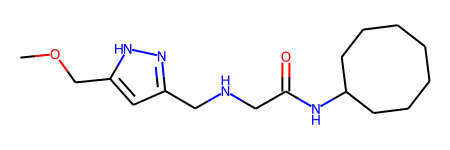

In [ ]:
to_mol(base_smile)

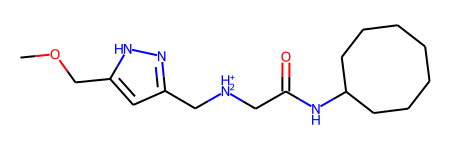

In [ ]:
to_mol(base_smile2)

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     MaxRingFilter(None, 8)],
                    [], 
                    fail_score=0., log=False)

In [ ]:
fp_filter = FPFilter(ECFP6(to_mol(base_smile)), 'ECFP6', 'tanimoto',
                    score=PassThroughScore())

fp_filter2 = FPFilter(ECFP6(to_mol(base_smile)), 'ECFP6', 'tanimoto',
                    score=PassThroughScore())

In [ ]:
queue = [[base_smile, base_smile2]]
df = pd.DataFrame(columns=['smiles', 'tanimoto', 'plogp'])

iters = 0
while queue:
    print(iters, df.shape)
    next_batch = queue.pop(0)
    combi = flatten_list_of_lists(maybe_parallel(add_atom_combi, next_batch, atom_types=['C', 'N', 'O', -1, -2]))
    combi = [i for i in combi if i is not None]
    combi = [i for i in combi if not '.' in i]
    
    sims = np.array(fp_filter(combi, with_score=True))
    plogps = maybe_parallel(penalized_logp, to_mols(combi))
    sample_df = pd.DataFrame(combi, columns=['smiles'])
    sample_df['tanimoto'] = sims
    sample_df['plogp'] = plogps
    
    df = pd.concat([df, sample_df])
    df.drop_duplicates(subset='smiles', inplace=True)
    
    refined = df[df.tanimoto>0.6]
    refined_logp = refined[refined.plogp>np.percentile(refined.plogp, 90)]
    refined_tanimoto = refined[refined.tanimoto>np.percentile(refined.tanimoto, 90)]
    
    next_batch = list(refined_logp.smiles.values)+list(refined_tanimoto.smiles.values)
    queue.append(next_batch)
    iters += 1
    if iters>6:
        break

0 (0, 3)
1 (138, 3)
2 (746, 3)
3 (2584, 3)
4 (6656, 3)
5 (16060, 3)
6 (39131, 3)


In [ ]:
iters = 0
while queue:
    print(iters, df.shape)
    next_batch = queue.pop(0)
    combi = flatten_list_of_lists(maybe_parallel(add_atom_combi, next_batch, atom_types=['C', 'N', 'O', -1, -2]))
    combi = [i for i in combi if i is not None]
    combi = [i for i in combi if not '.' in i]
    
    sims = np.array(fp_filter(combi, with_score=True))
    plogps = maybe_parallel(penalized_logp, to_mols(combi))
    sample_df = pd.DataFrame(combi, columns=['smiles'])
    sample_df['tanimoto'] = sims
    sample_df['plogp'] = plogps
    
    df = pd.concat([df, sample_df])
    df.drop_duplicates(subset='smiles', inplace=True)
    
    refined = df[df.tanimoto>0.75]
    refined_logp = refined[refined.plogp>np.percentile(refined.plogp, 95)]
#     refined_tanimoto = refined[refined.tanimoto>np.percentile(refined.tanimoto, 90)]
    
    next_batch = list(refined_logp.smiles.values) #+list(refined_tanimoto.smiles.values)
    queue.append(next_batch)
    iters += 1
    if iters>5:
        break

0 (99526, 3)
1 (274398, 3)
2 (274398, 3)
3 (274398, 3)
4 (274398, 3)
5 (274398, 3)


In [ ]:
queue = [['COCc1cc(CNCC(=O)NC2CCCCC2)n[nH]1']]
df2 = pd.DataFrame(columns=['smiles', 'tanimoto', 'plogp'])

iters = 0
while queue:
    print(iters, df2.shape)
    next_batch = queue.pop(0)
    combi = flatten_list_of_lists(maybe_parallel(add_atom_combi, next_batch, atom_types=['C', 'N', 'O', -1, -2]))
    combi = [i for i in combi if i is not None]
    combi = [i for i in combi if not '.' in i]
    
    sims = np.array(fp_filter(combi, with_score=True))
    plogps = maybe_parallel(penalized_logp, to_mols(combi))
    sample_df = pd.DataFrame(combi, columns=['smiles'])
    sample_df['tanimoto'] = sims
    sample_df['plogp'] = plogps
    
    df2 = pd.concat([df2, sample_df])
    df2.drop_duplicates(subset='smiles', inplace=True)
    
    refined = df2[df2.tanimoto>0.5]
    refined_logp = refined[refined.plogp>np.percentile(refined.plogp, 85)]
#     refined_tanimoto = refined[refined.tanimoto>np.percentile(refined.tanimoto, 90)]
    
    next_batch = list(refined_logp.smiles.values) #+list(refined_tanimoto.smiles.values)
    queue.append(next_batch)
    iters += 1
    if iters>5:
        break

0 (0, 3)
1 (66, 3)
2 (683, 3)
3 (1940, 3)
4 (5905, 3)
5 (18013, 3)


In [ ]:
df = pd.concat([df, df2])

In [ ]:
df.shape

(333733, 3)

In [ ]:
df.drop_duplicates(subset='smiles', inplace=True)
df.shape

(308065, 3)

<AxesSubplot:>

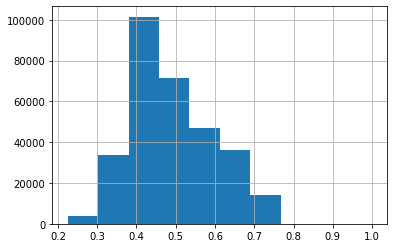

In [ ]:
df.tanimoto.hist()

In [ ]:
df[(df.tanimoto>0.75) & (df.plogp>-1)]

,smiles,tanimoto,plogp
351,COCc1cc(CNCC(=O)NC2CCCCC2)n[nH]1,0.950000,-0.109288
152,CCOCc1cc(CNCC(=O)NC2CCCCC2)n[nH]1,0.764706,0.094081
1691,COCc1cc(CNCC(=O)NC2CCCC2)n[nH]1,0.916667,-0.404989
1700,COCc1cc(CNCC(=O)NC2CCC(C)CC2)n[nH]1,0.761194,-0.059820
1199,CC(=O)OCc1cc(CNCC(=O)NC2CCCCC2)n[nH]1,0.764706,-0.202492
1879,NOCc1cc(CNCC(=O)NC2CCCCC2)n[nH]1,0.761194,-0.897816
2064,O=C(CNCc1cc(COO)[nH]n1)NC1CCCCC1,0.772727,-0.450002
2065,COCOCc1cc(CNCC(=O)NC2CCCCC2)n[nH]1,0.771429,-0.343891
3373,COCc1cc(CNCC(=O)NC2CCC2)n[nH]1,0.883333,-0.721036
4591,CNOCc1cc(CNCC(=O)NC2CCCCC2)n[nH]1,0.753623,-0.853893


In [ ]:
df[(df.tanimoto>0.5) & (df.plogp>-4)]

,smiles,tanimoto,plogp
48,COCc1cc(CNCC(=O)NC2CCCCCC2)n[nH]1,0.983051,-3.315862
71,CCCC(CCC)NC(=O)CNCc1cc(COC)[nH]n1,0.520000,0.081153
59,CCOCc1cc(CNCC(=O)NC2CCCCCC2)n[nH]1,0.791045,-3.113671
153,COCc1cc(CNC(=O)NC2CCCCCC2)n[nH]1,0.605634,-2.824882
250,COCc1cc(CNCC(=O)C2CCCCCC2)n[nH]1,0.605634,-3.038688
...,...,...,...
80280,COCc1cc(CNCC(=O)NC2(C=O)CCC(C(C)(C)C)CC2)n[nH]1,0.506024,-0.600947
80290,COCc1cc(CNCC(=O)NC2(C)CCC(C(C)(C)C)C2)n[nH]1,0.506024,-0.796053
80912,COCc1cc(CNCC(=O)NC2(C(C)C)CCC(C)CC2)n[nH]1,0.544304,-0.141935
80918,COCc1cc(CNCC(=O)NC2(C(C)C)CCC(C(C)O)CC2)n[nH]1,0.506024,-1.269784


In [ ]:
agent.update_dataset_from_inputs(df[(df.tanimoto>0.5) & (df.plogp>-4)].smiles.values)

In [ ]:
agent.train_supervised(256, 4, 1e-4)

Epoch,Train Loss,Valid Loss,Time
0,0.28955,0.28998,00:14
1,0.25632,0.25289,00:14
2,0.24539,0.24599,00:14
3,0.24294,0.24492,00:14


In [ ]:
agent.base_model.load_state_dict(agent.model.state_dict())

<All keys matched successfully>

In [ ]:
preds, _ = agent.model.sample_no_grad(1000, 90)
sampled = agent.reconstruct(preds)

In [ ]:
sampled = list(set(sampled))
len(sampled)

995

In [ ]:
sampled = [i for i in sampled if to_mol(i) is not None]

In [ ]:
len(sampled)

976

In [ ]:
def scale_plogp(plogp):
    min_val = -15
    max_val = 5
    return (plogp - min_val)/(max_val - min_val)

In [ ]:
refresh_global_pool()

In [ ]:
fp_filter = FPFilter(ECFP6(to_mol(base_smile)), 'ECFP6', 'tanimoto',
                    score=PassThroughScore(), fp_thresh=0.5)
plogp_filter = PropertyFilter(penalized_logp, score=PropertyFunctionScore(scale_plogp))

score_template = Template([ValidityFilter(), 
                     SingleCompoundFilter(), 
                     MaxRingFilter(None, 8),
                     fp_filter],
                    [fp_filter, plogp_filter], 
                    fail_score=-1., log=False)

In [ ]:
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss = PolicyLoss(pg, 'PPO', 
                   value_head=ValueHead(256), 
                   v_update_iter=2, 
                   vopt_kwargs={'lr':1e-3})

In [ ]:
gen_bs = 1500

sampler1 = ModelSampler(vocab, agent.model, 'live', 1000, 0.6, gen_bs)
sampler2 = ModelSampler(vocab, agent.base_model, 'base', 1000, 0., gen_bs)
sampler3 = LogSampler('samples', 'rewards', 10, 95, 100)
sampler4 = TokenSwapSampler('samples', 'rewards', 10, 95, 100, vocab, 0.1)
sampler5 = LogEnumerator('samples', 'rewards', 10, 95, 3, atom_types=['C', 'N', 'O', -1, -2])

samplers = [sampler1, sampler2, sampler3, sampler4, sampler5]

In [ ]:
supervised_cb = SupevisedCB(agent, 200, 0.5, 97, 5e-5, 64)
live_max = MaxCallback('rewards', 'live')
live_p90 = PercentileCallback('rewards', 'live', 90)

cbs = [supervised_cb, live_p90, live_max]

In [ ]:
template_cb = TemplateCallback(score_template, prefilter=True)

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, reward_cbs=[], loss_cbs=[loss],
                 cbs=cbs)

In [ ]:
set_global_pool(8)

In [ ]:
env.fit(200, 90, 1000, 5)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
0,1.292,1.292,1.000,1.000,192,1.292,0.960,1.000,0.933,1.291,1.000,-0.012,1.386,1.436
5,1.313,1.313,0.990,1.000,194,1.313,0.970,1.000,0.950,1.314,0.991,-0.015,1.404,1.470
10,1.308,1.308,0.974,1.000,192,1.308,0.960,1.000,0.933,1.324,0.955,-0.016,1.411,1.466
15,1.315,1.315,0.962,1.000,186,1.315,0.930,1.000,0.883,1.322,0.962,-0.028,1.411,1.451
20,1.323,1.323,0.909,0.995,186,1.323,0.930,1.000,0.883,1.328,0.915,-0.029,1.412,1.490
25,1.318,1.318,0.904,1.000,188,1.318,0.940,1.000,0.900,1.321,0.917,-0.030,1.406,1.519
30,1.315,1.315,0.866,1.000,187,1.315,0.935,1.000,0.892,1.312,0.897,-0.028,1.402,1.494
35,1.316,1.316,0.910,1.000,189,1.316,0.945,1.000,0.908,1.325,0.899,-0.023,1.424,1.485
40,1.321,1.321,0.843,0.995,185,1.321,0.925,0.990,0.875,1.331,0.810,-0.030,1.423,1.508
45,1.322,1.322,0.871,1.000,194,1.322,0.970,1.000,0.950,1.325,0.868,-0.033,1.422,1.496


Epoch,Train Loss,Valid Loss,Time
0,0.18464,0.18104,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.18862,0.19160,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.25381,0.20261,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.19192,0.22591,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.25424,0.23500,00:00


In [ ]:
gen_df = pd.DataFrame(env.log.df.samples.values, columns=['smiles'])
gen_df['tanimoto'] = np.array(fp_filter(gen_df.smiles.values, with_score=True))
gen_df['plogp'] = maybe_parallel(penalized_logp, to_mols(gen_df.smiles.values))

In [ ]:
df['score'] = df.apply(lambda row: row['tanimoto'] + (row['plogp']+15)/(5+15), axis=1)

In [ ]:
gen_df['score'] = gen_df.apply(lambda row: row['tanimoto'] + (row['plogp']+15)/(5+15), axis=1)

In [ ]:
df = pd.concat([df, gen_df])
print(df.shape)
df.drop_duplicates(subset='smiles', inplace=True)
print(df.shape)

(401921, 4)
(331776, 4)


In [ ]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_nc.pt'))
agent.update_dataset_from_inputs(df[df.score>1.3].smiles.values)
agent.train_supervised(256, 2, 1e-4)
agent.update_dataset_from_inputs(df[df.score>1.4].smiles.values)
agent.train_supervised(256, 2, 1e-4)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.24768,0.25896,00:11
1,0.25570,0.24538,00:11


Epoch,Train Loss,Valid Loss,Time
0,0.20205,0.20242,00:01
1,0.20818,0.19906,00:01


<All keys matched successfully>

In [ ]:
env.fit(200, 90, 500, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
1000,1.410,1.410,0.386,1.000,189,1.410,0.945,1.000,0.908,1.413,0.321,-0.023,1.463,1.486
1010,1.409,1.409,0.347,0.984,193,1.409,0.965,0.991,0.942,1.416,0.310,-0.040,1.468,1.508
1020,1.418,1.418,0.301,0.990,196,1.418,0.980,1.000,0.967,1.421,0.259,-0.043,1.461,1.504
1030,1.423,1.423,0.242,0.985,194,1.423,0.970,0.991,0.950,1.429,0.175,-0.030,1.473,1.523
1040,1.414,1.414,0.256,0.980,199,1.414,0.995,0.983,0.992,1.420,0.210,-0.032,1.475,1.507
1050,1.420,1.420,0.236,0.990,195,1.420,0.975,1.000,0.958,1.429,0.209,-0.032,1.474,1.523
1060,1.425,1.425,0.266,0.984,188,1.425,0.940,0.991,0.900,1.431,0.167,-0.042,1.484,1.515
1070,1.423,1.423,0.174,0.963,190,1.423,0.950,0.945,0.917,1.438,0.091,-0.025,1.484,1.522
1080,1.423,1.423,0.190,0.979,195,1.423,0.975,0.983,0.958,1.426,0.183,-0.030,1.470,1.505
1090,1.418,1.418,0.277,0.979,191,1.418,0.955,0.973,0.925,1.428,0.207,-0.035,1.484,1.513


Epoch,Train Loss,Valid Loss,Time
0,0.18108,0.17204,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.16890,0.17047,00:00


In [ ]:
gen_df = pd.DataFrame(env.log.df.samples.values, columns=['smiles'])
gen_df['tanimoto'] = np.array(fp_filter(gen_df.smiles.values, with_score=True))
gen_df['plogp'] = maybe_parallel(penalized_logp, to_mols(gen_df.smiles.values))

gen_df['score'] = gen_df.apply(lambda row: row['tanimoto'] + (row['plogp']+15)/(5+15), axis=1)

df = pd.concat([df, gen_df])
print(df.shape)
df.drop_duplicates(subset='smiles', inplace=True)
print(df.shape)

(396550, 4)
(348653, 4)


In [ ]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_nc.pt'))
agent.update_dataset_from_inputs(df[df.score>1.3].smiles.values)
agent.train_supervised(256, 2, 1e-4)
agent.update_dataset_from_inputs(df[df.score>1.4].smiles.values)
agent.train_supervised(256, 2, 1e-4)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.25657,0.22501,00:16
1,0.23636,0.21531,00:16


Epoch,Train Loss,Valid Loss,Time
0,0.19160,0.19768,00:04
1,0.18557,0.19605,00:04


<All keys matched successfully>

In [ ]:
env.fit(200, 90, 500, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
1500,1.424,1.424,0.249,0.995,193,1.424,0.965,1.000,0.942,1.417,0.239,-0.018,1.466,1.507
1510,1.427,1.427,0.263,0.990,198,1.427,0.990,0.992,0.983,1.431,0.229,-0.011,1.470,1.506
1520,1.431,1.431,0.284,0.995,197,1.431,0.985,1.000,0.975,1.437,0.179,-0.009,1.469,1.514
1530,1.431,1.431,0.297,0.979,195,1.431,0.975,0.974,0.958,1.436,0.209,-0.025,1.474,1.541
1540,1.430,1.430,0.250,1.000,196,1.430,0.980,1.000,0.967,1.436,0.147,-0.019,1.482,1.539
1550,1.435,1.435,0.230,1.000,196,1.435,0.980,1.000,0.967,1.445,0.095,-0.021,1.491,1.534
1560,1.435,1.435,0.185,0.995,195,1.435,0.975,1.000,0.958,1.438,0.130,-0.022,1.482,1.527
1570,1.435,1.435,0.236,0.990,195,1.435,0.975,0.983,0.958,1.436,0.200,-0.026,1.476,1.514
1580,1.431,1.431,0.262,0.990,195,1.431,0.975,1.000,0.958,1.438,0.200,-0.031,1.480,1.515
1590,1.438,1.438,0.223,0.984,193,1.438,0.965,1.000,0.942,1.441,0.150,-0.019,1.486,1.512


Epoch,Train Loss,Valid Loss,Time
0,0.16690,0.14639,00:00


Epoch,Train Loss,Valid Loss,Time
0,0.15761,0.12463,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.19484,0.22054,00:01


In [ ]:
gen_df = pd.DataFrame(env.log.df.samples.values, columns=['smiles'])
print(gen_df.shape)
gen_df = gen_df[~gen_df.smiles.isin(df.smiles)]
print(gen_df.shape)
gen_df['tanimoto'] = np.array(fp_filter(gen_df.smiles.values, with_score=True))
gen_df['plogp'] = maybe_parallel(penalized_logp, to_mols(gen_df.smiles.values))

gen_df['score'] = gen_df.apply(lambda row: row['tanimoto'] + (row['plogp']+15)/(5+15), axis=1)


(85504, 1)
(20542, 1)


In [ ]:
df = pd.concat([df, gen_df])
print(df.shape)
df.drop_duplicates(subset='smiles', inplace=True)
print(df.shape)

(369195, 4)
(369195, 4)


In [ ]:
agent.model.load_state_dict(torch.load('../nbs/untracked_files/lstm_lm_zinc_nc.pt'))
agent.update_dataset_from_inputs(df[(df.score>1.3) & (df.tanimoto>0.6)].smiles.values)
agent.train_supervised(256, 3, 1e-4)
agent.update_dataset_from_inputs(df[(df.score>1.4) & (df.tanimoto>0.7)].smiles.values)
agent.train_supervised(256, 3, 1e-4)
agent.base_model.load_state_dict(agent.model.state_dict())

Epoch,Train Loss,Valid Loss,Time
0,0.20903,0.24675,00:20
1,0.18153,0.22908,00:20
2,0.21275,0.22740,00:20


Epoch,Train Loss,Valid Loss,Time
0,0.13301,0.18906,00:00
1,0.16045,0.17876,00:00
2,0.11785,0.17825,00:00


<All keys matched successfully>

In [ ]:
env.fit(200, 90, 500, 10)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,live_diversity,live_valid,live_rewards,live_new,PPO,rewards_live_p90,rewards_live_max
2040,1.423,1.423,0.370,0.979,192,1.423,0.960,0.973,0.933,1.415,0.241,0.025,1.491,1.695
2050,1.424,1.424,0.228,0.984,193,1.424,0.965,0.982,0.942,1.420,0.150,0.025,1.493,1.517
2060,1.428,1.428,0.286,0.979,192,1.428,0.960,0.973,0.933,1.428,0.179,0.021,1.494,1.775
2070,1.431,1.431,0.149,0.963,188,1.431,0.940,0.954,0.900,1.433,0.083,-0.017,1.506,1.646
2080,1.435,1.435,0.187,0.965,198,1.435,0.990,0.958,0.983,1.436,0.085,0.020,1.490,1.695
2090,1.428,1.428,0.212,0.947,189,1.428,0.945,0.927,0.908,1.432,0.119,-0.020,1.493,1.541
2100,1.426,1.426,0.185,0.958,189,1.426,0.945,0.954,0.908,1.435,0.110,-0.006,1.505,1.646
2110,1.438,1.438,0.218,0.970,197,1.438,0.985,0.974,0.975,1.437,0.077,0.043,1.485,1.695
2120,1.440,1.440,0.224,0.934,196,1.440,0.980,0.922,0.967,1.439,0.095,0.024,1.502,1.695
2130,1.437,1.437,0.229,0.979,192,1.437,0.960,0.964,0.933,1.440,0.098,0.036,1.496,1.597


Epoch,Train Loss,Valid Loss,Time
0,0.20543,0.22796,00:01


Epoch,Train Loss,Valid Loss,Time
0,0.12255,0.15897,00:01


In [ ]:
gen_df = pd.DataFrame(env.log.df.samples.values, columns=['smiles'])
print(gen_df.shape)
gen_df = gen_df[~gen_df.smiles.isin(df.smiles)]
print(gen_df.shape)
gen_df['tanimoto'] = np.array(fp_filter(gen_df.smiles.values, with_score=True))
gen_df['plogp'] = maybe_parallel(penalized_logp, to_mols(gen_df.smiles.values))

gen_df['score'] = gen_df.apply(lambda row: row['tanimoto'] + (row['plogp']+15)/(5+15), axis=1)


(117647, 1)
(31351, 1)


In [ ]:
df = pd.concat([df, gen_df])
print(df.shape)
df.drop_duplicates(subset='smiles', inplace=True)
print(df.shape)

(400546, 4)
(400546, 4)


In [ ]:
df[(df.tanimoto>0.75)]

,smiles,tanimoto,plogp,score
0,CCOCc1cc(CNCC(=O)NC2CCCCCCC2)n[nH]1,0.805970,-6.326342,1.239653
1,C=COCc1cc(CNCC(=O)NC2CCCCCCC2)n[nH]1,0.782609,-6.537505,1.205733
2,C#COCc1cc(CNCC(=O)NC2CCCCCCC2)n[nH]1,0.757143,-7.066460,1.153820
3,NCOCc1cc(CNCC(=O)NC2CCCCCCC2)n[nH]1,0.768116,-7.362624,1.149985
4,N=COCc1cc(CNCC(=O)NC2CCCCCCC2)n[nH]1,0.757143,-7.068713,1.153707
...,...,...,...,...
97038,COCc1cc(CNCC(=O)NC2CCC(NCc3cc(CNCC(=O)NC4CCCCC...,0.760000,-0.865956,1.466702
97759,COCc1cc(CNCC(=O)NC2CCC(NC(=O)OCc3cc(CNCC(=O)NC...,0.770270,-0.854922,1.477524
97995,COCc1cc(COC(=O)OCc2cc(CNCC(=O)NC3CCCCC3)n[nH]2...,0.770270,-0.351636,1.502688
103839,COCc1cc(CNCC(=O)NC2CCC(C3CCCCCC3)CC2)n[nH]1,0.760563,-2.258549,1.397636
